## CommunityViz Existing Development Analysis

The CommunityViz project is being led by the Piedmont Authority for Regional Transportation (PART). The goal of this project is to establish a faster, more efficient and accurate process for generating future socio-econcomic data that feeds into the Regional Travel Demand Model, also maintained by PART. The CommunityViz model needs parcel data with a few attributes to get started. One of those attributes is `Built_SQF` which is a value that represents the amount of existing development on the parcel. CommunityViz needs this value to remove existing development so the model knows how much area is left to receive potential growth. After the model was run, the results were carefully scrutinized. Initial findings revealed development in areas the project committee knew to be fully developed. When the parcel data was examined, it was discovered that many parcels were missing a value for `Built_SQF`. It would be impossible to recommend that local jurisdictions revisit the parcel data and locate and populate all missing values. This analysis will attempt to use building footprint data from NCOneMap as a possible solution to fill the missing data. The analysis will compare the existing data in `Built_SQF` to the sum of the building footprint data by parcel. If it is determined to be a solution, the parcels that are missing `Built_SQF` will be filled with the footprint data.

In [246]:
import fiona
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
sns.set(font_scale=1.1)

In [247]:
# Read in geodatabase
layers = fiona.listlayers(r"D:\Project Data\CommunityViz\footprint_analysis\footprint_analysis.gdb")

In [248]:
# Show the layers in the geodatabase
for layer in layers:
    print(layer)

ptrm_footprints
Orange_Co_Buildings
Alamance_Co_Buildings
Davie_Co_buildings
Rockingham_Co_Buildings
Guilford_Co_Buildings
Randolph_Co_Buildings
Stokes_Co_Buildings
Forsyth_Co_Buildings
Davidson_Co_Buildings
PTRM_parcels_20200701_SummarizeWithin


In [249]:
# Select the parcel layer for analysis
gdf = gpd.read_file(r"D:\Project Data\CommunityViz\footprint_analysis\footprint_analysis.gdb",
                    driver = 'FileGDB',
                    layer = 'PTRM_parcels_20200701_SummarizeWithin')

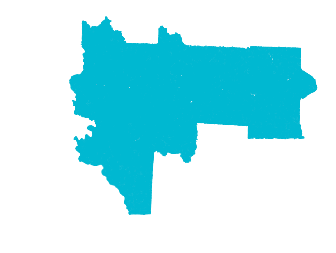

In [250]:
# Quick plot
fig_dims = (6,4)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_axis_off()

gdf.plot(ax=ax, facecolor='#00b8d1', edgecolor='face', linewidth=0.4)

In [251]:
# List each column in the layer
#list(gdf)

In [252]:
# Select layers of interest for analysis
gdf = gdf[['PARNO', 'TYPE18', 'DEV18', 'CNTYNAME', 'Parcel_SQF',
           'Parcel_Acre', 'DU', 'Built_SQF', 'Built_Acre',
           'STRUCTYEAR', 'SUM_Area_SQUAREFEET', 'SUM_HTD_SQ_FT', 'geometry']]

# Rename columns
gdf = gdf.rename(columns={
    'PARNO'               : 'ParcelID',
    'TYPE18'              : 'Place Type',
    'DEV18'               : 'Dev Status',
    'CNTYNAME'            : 'County',
    'DU'                  : 'Dwelling Units',
    'Built_SQF'           : 'Built Sq Feet',
    'STRUCTYEAR'          : 'Year Built',
    'SUM_Area_SQUAREFEET' : 'Structure Sq Feet',
    'SUM_HTD_SQ_FT'       : 'Heated Sq Feet'
})

In [253]:
# Preview data
gdf.head()

,ParcelID,Place Type,Dev Status,County,Parcel_SQF,Parcel_Acre,Dwelling Units,Built Sq Feet,Built_Acre,Year Built,Structure Sq Feet,Heated Sq Feet,geometry
0,5972253371,RL,UN,Stokes,2.311652e+04,0.530684,0,NaN,NaN,0,0.000000,0.0,(POLYGON ((1572466.979171336 925358.0103675872...
1,5972258601,RL,UNDR,Stokes,1.056269e+06,24.248688,1,7095.892275,0.1629,0,7095.720654,10208.0,(POLYGON ((1573128.416824847 925447.9373530897...
2,5971583262,RL,UN,Stokes,6.486288e+05,14.890528,0,NaN,NaN,0,0.000000,0.0,(POLYGON ((1575000.000023931 918434.9477701783...
3,5971994414,RL,UN,Stokes,2.480579e+06,56.946481,0,NaN,NaN,0,0.000000,0.0,(POLYGON ((1579536.645806253 918749.0521288365...
4,5972969470,RL,UN,Stokes,1.360138e+05,3.122459,0,NaN,NaN,0,0.000000,0.0,(POLYGON ((1580285.979281336 926372.7813039273...


In [254]:
# Generate summary statistics for attributes of interest
gdf[['Built Sq Feet', 'Structure Sq Feet', 'Heated Sq Feet']].describe().round(2)

,Built Sq Feet,Structure Sq Feet,Heated Sq Feet
count,476617.00,593777.00,593777.00
mean,3286.85,2492.54,2806.97
std,12383.61,11395.98,20316.86
min,0.00,0.00,0.00
25%,1480.68,77.61,0.00
50%,2062.82,1609.37,1344.00
75%,2903.70,2477.44,2256.00
max,1759646.19,1739133.86,4988063.00


In [255]:
# Get total nulls and calculate percent
n = gdf['Built Sq Feet'].isnull().sum()
p = round((n/len(gdf['Built Sq Feet']))*100,2)

print('There are {:,} parcels where `Built Sq Feet` is empty.'.format(n))
print('That represents {}% of total parcels in the PTRM study area.'.format(p))

There are 117,160 parcels where `Built Sq Feet` is empty.
That represents 19.73% of total parcels in the PTRM study area.


While nearly 20% of parcels are missing the `Built Sq Feet` attribute, some of those are likely to be parcels with no structures which means the `Built Sq Feet` attribute should be empty. However, there are cases where the attribute is empty but there IS a structure on the property? That is why data for building footprints was brought in and joined to the parcel data.



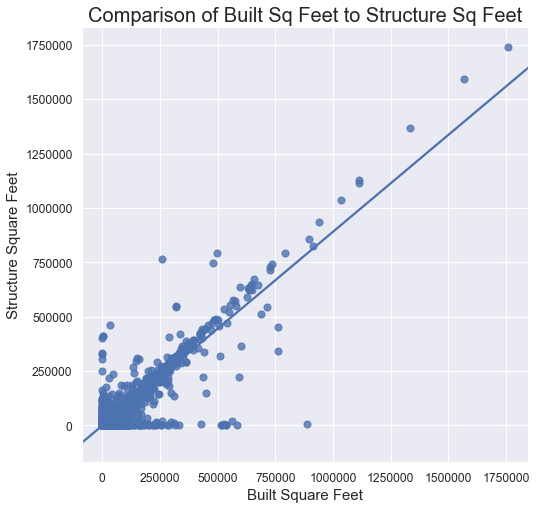

In [256]:
# Define parameters for plot
fig_dims = (8,8)
fig, ax = plt.subplots(figsize=fig_dims)

ptrm_plot = sns.regplot(data=gdf,
                x='Built Sq Feet',
                y='Structure Sq Feet',
                ci=None,
                scatter_kws={'s':50},
                ax=ax)

ptrm_plot.set_title("Comparison of Built Sq Feet to Structure Sq Feet", fontsize=20)
ptrm_plot.set_xlabel("Built Square Feet", fontsize=15)
ptrm_plot.set_ylabel("Structure Square Feet", fontsize=15)
plt.show()

In [257]:
# Calculate correlation coefficient for study area
ptrm_corr = gdf['Structure Sq Feet'].corr(gdf['Built Sq Feet'])

print('The correlation between `Structure Sq Feet` and `Built Sq Feet` in study area is {}.'.format(round(ptrm_corr,4)))

The correlation between `Structure Sq Feet` and `Built Sq Feet` in study area is 0.9334.


We had been comparing the `Built Sq Feet` attribute from the parcel data to `Structure Sq Feet` which was calculated from the `SHAPE_AREA` attribute in the footprint data. The final analysis will compare `Built Sq Feet` to `Heated Sq Feet` which also came from the footprint data.

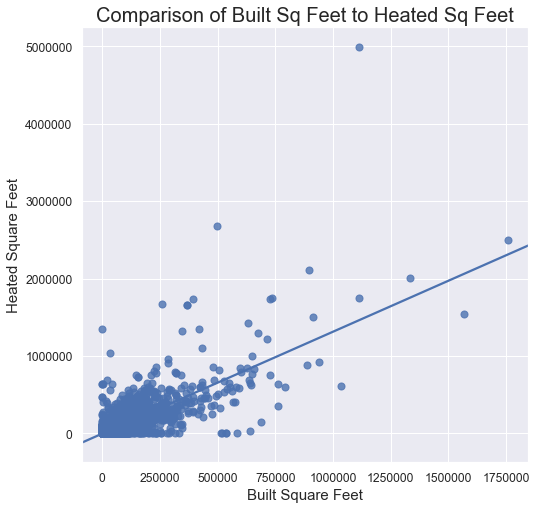

In [258]:
# Define parameters for plot
fig_dims = (8,8)
fig, ax = plt.subplots(figsize=fig_dims)

ptrm_plot_htd = sns.regplot(data=gdf,
                x='Built Sq Feet',
                y='Heated Sq Feet',
                ci=None,
                scatter_kws={'s':50},
                ax=ax)

ptrm_plot_htd.set_title("Comparison of Built Sq Feet to Heated Sq Feet", fontsize=20)
ptrm_plot_htd.set_xlabel("Built Square Feet", fontsize=15)
ptrm_plot_htd.set_ylabel("Heated Square Feet", fontsize=15)
plt.show()

In [259]:
# Calculate correlation coefficient for study area
ptrm_corr_htd = gdf['Heated Sq Feet'].corr(gdf['Built Sq Feet'])

print('The correlation between `Heated Sq Feet` and `Built Sq Feet` in study area is {}.'.format(round(ptrm_corr_htd,4)))

The correlation between `Heated Sq Feet` and `Built Sq Feet` in study area is 0.8017.


We can see that the relationship between `Heated Sq Feet` and `Built Sq Feet` is not nearly as strong.

Let's select those parcels whose `Built Sq Feet` attribute is empty but has a value from the footprint data.

In [260]:
na = len(gdf[(gdf['Built Sq Feet'].isnull()) & (gdf['Structure Sq Feet'] > 0)])
p = round((na/len(gdf['Built Sq Feet']))*100,2)

print('There are {:,} parcels where `Built Sq Feet` is empty but there is a structure.'.format(na))
print('That represents {}% of total parcels in the PTRM study area.'.format(p))

There are 21,364 parcels where `Built Sq Feet` is empty but there is a structure.
That represents 3.6% of total parcels in the PTRM study area.


In [261]:
# Update the missing values
gdf.loc[(gdf['Built Sq Feet'].isnull()) & (gdf['Year Built'] <= 2017), "Built Sq Feet"] = gdf['Structure Sq Feet']

In [262]:
# Verify data update
na = len(gdf[(gdf['Built Sq Feet'].isnull()) & (gdf['Structure Sq Feet'] > 0) & (gdf['Year Built'] < 2017)])
p = round((na/len(gdf['Built Sq Feet']))*100,2)

print('There are {:,} parcels where `Built Sq Feet` is empty but there is a structure.'.format(na))
print('That represents {}% of total parcels in the PTRM study area.'.format(p))

There are 0 parcels where `Built Sq Feet` is empty but there is a structure.
That represents 0.0% of total parcels in the PTRM study area.


In [263]:
# Write data to GeoJSON file that can be read into ArcGIS
gdf.to_file(r"D:\Project Data\CommunityViz\footprint_analysis\ptrm_parcels_20200930.json", driver='GeoJSON')